# **授权**

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# **指定文件目录**

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os

os.chdir("drive/Colab Notebooks") 
!ls

“com2018.ipynb”的副本  data_all.csv


# **安装必要的包和库**

In [0]:
!pip install joblib
!pip install pandas
!pip install gbdt
!pip install xgboost
!pip install lightgbm
!pip install imbalanced-learn
!pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git


# **导入相关库**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble.forest import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn.metrics import roc_curve, auc

# **读取数据并拆分数据集**

In [0]:
data_all = pd.read_csv('./data_all.csv')
Y = data_all['status']
X = data_all.drop('status', axis=1)

# 按7:3拆分成training和testing集，随机种子为2018。随机种子的目的是使每次拆分的结果一致
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=2018)

# **数据初探**

In [0]:
X_train.info() # 查看数据信息以及是否有缺失值

# 查看label的分布，存在数据不平衡问题的。直接初步建模也验证了这一现象。
plt.hist(Y_train, bins=3)
plt.show()
plt.hist(Y_test, bins=3)
plt.show()

# **数据不平衡处理**

In [9]:
over_samples = SMOTE(random_state=2018) 
over_samples_X,over_samples_y = over_samples.fit_sample(X_train, Y_train)

# 重抽样前的类别比例
print(Y_train.value_counts()/len(Y_train))
# 重抽样后的类别比例
print(pd.Series(over_samples_y).value_counts()/len(over_samples_y))

0    0.749324
1    0.250676
Name: status, dtype: float64
1    0.5
0    0.5
dtype: float64


# **建模：Logistic回归**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6299929922915207 0.7038433851835624
              precision    recall  f1-score   support

           0       0.84      0.63      0.72      1068
           1       0.37      0.64      0.46       359

   micro avg       0.63      0.63      0.63      1427
   macro avg       0.60      0.63      0.59      1427
weighted avg       0.72      0.63      0.65      1427



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


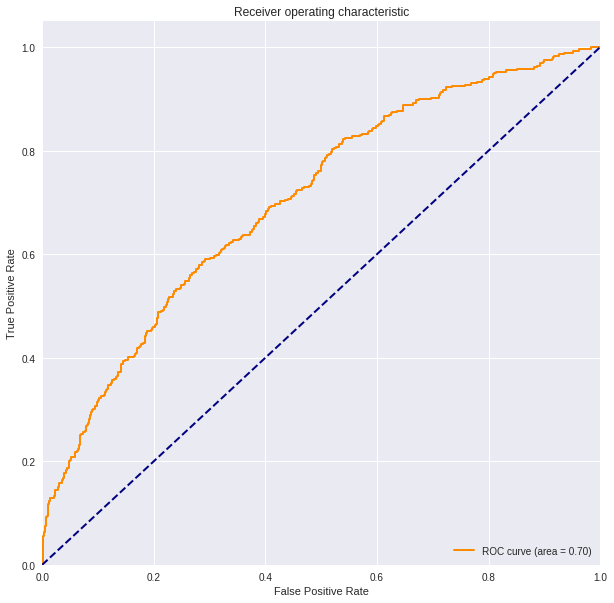

In [26]:
clf = LogisticRegression(random_state =2018)
clf.fit(over_samples_X, over_samples_y)

predict_Y = lr.predict(X_test)
predict_prob_y = clf.predict_proba(X_test)[:, 1]

acc = metrics.accuracy_score(Y_test,predict_Y)
auc = metrics.roc_auc_score(Y_test,predict_prob_y)
print(acc,auc)
print(metrics.classification_report(Y_test, predict_Y))

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(Y_test, predict_prob_y, pos_label=1)

lw = 2
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# **建模: Decision Tree**

0.6874562018220042 0.6099783001053696
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1068
           1       0.39      0.45      0.42       359

   micro avg       0.69      0.69      0.69      1427
   macro avg       0.60      0.61      0.60      1427
weighted avg       0.70      0.69      0.69      1427



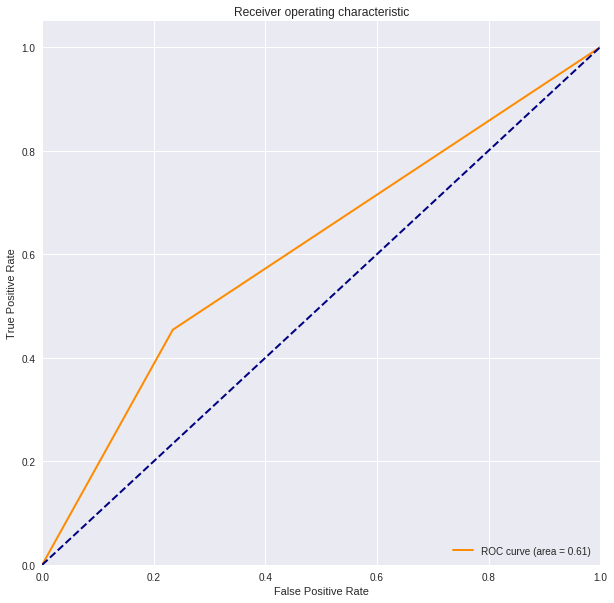

In [31]:
clf = tree.DecisionTreeClassifier(random_state =2018)
clf.fit(over_samples_X, over_samples_y)

predict_Y = clf.predict(X_test)
predict_prob_y = clf.predict_proba(X_test)[:, 1]

acc = metrics.accuracy_score(Y_test,predict_Y)
auc = metrics.roc_auc_score(Y_test,predict_prob_y,)
print(acc,auc)
print(metrics.classification_report(Y_test, predict_Y))

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(Y_test, predict_prob_y, pos_label=1)

lw = 2
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# 建模：SVM支持向量机

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7484232655921513 0.5
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1068
           1       0.00      0.00      0.00       359

   micro avg       0.75      0.75      0.75      1427
   macro avg       0.37      0.50      0.43      1427
weighted avg       0.56      0.75      0.64      1427



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


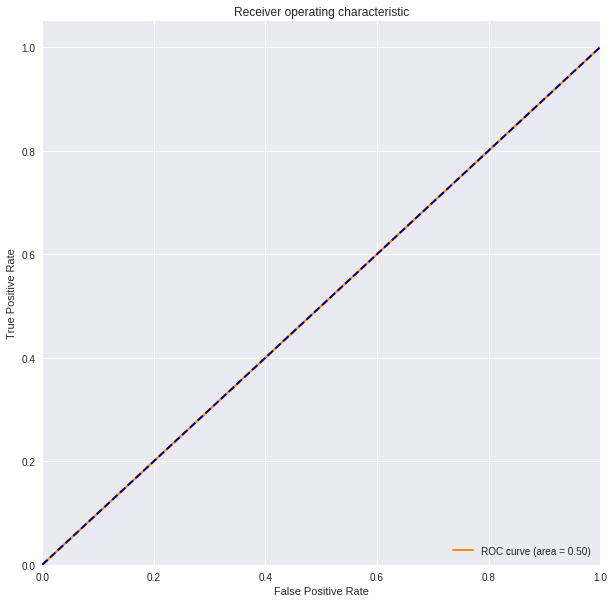

In [37]:
clf = svm.SVC(random_state =2018)
clf.fit(over_samples_X, over_samples_y)

predict_Y = clf.predict(X_test)
predict_prob_y = clf.decision_function(X_test)

acc = metrics.accuracy_score(Y_test,predict_Y)
auc = metrics.roc_auc_score(Y_test,predict_prob_y)
print(acc,auc)
print(metrics.classification_report(Y_test, predict_Y))

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(Y_test, predict_prob_y, pos_label=1)

lw = 2
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **建模: Random forest**

0.7105816398037842 0.7388266407937154
              precision    recall  f1-score   support

           0       0.84      0.75      0.80      1068
           1       0.44      0.58      0.50       359

   micro avg       0.71      0.71      0.71      1427
   macro avg       0.64      0.67      0.65      1427
weighted avg       0.74      0.71      0.72      1427



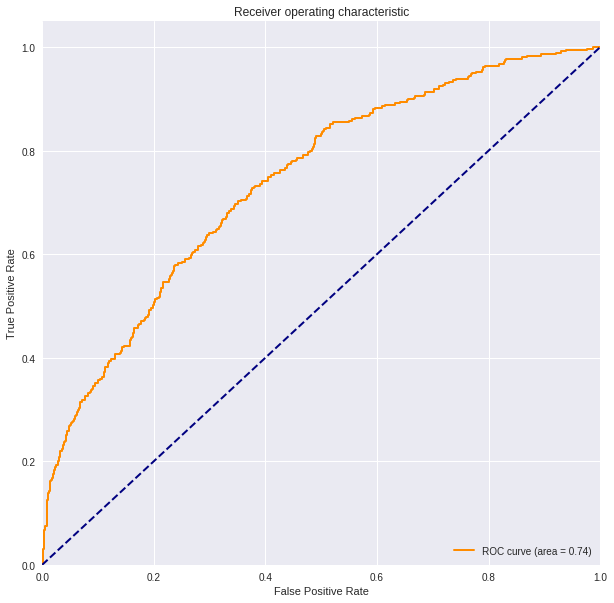

In [33]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(over_samples_X, over_samples_y)

predict_Y = clf.predict(X_test)
predict_prob_y = clf.predict_proba(X_test)[:, 1]

acc = metrics.accuracy_score(Y_test,predict_Y)
auc = metrics.roc_auc_score(Y_test,predict_prob_y)
print(acc,auc)
print(metrics.classification_report(Y_test, predict_Y))

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(Y_test, predict_prob_y, pos_label=1)

lw = 2
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **建模: GBDT**

0.7792571829011913 0.7773987251311905
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1068
           1       0.57      0.47      0.52       359

   micro avg       0.78      0.78      0.78      1427
   macro avg       0.70      0.68      0.69      1427
weighted avg       0.77      0.78      0.77      1427



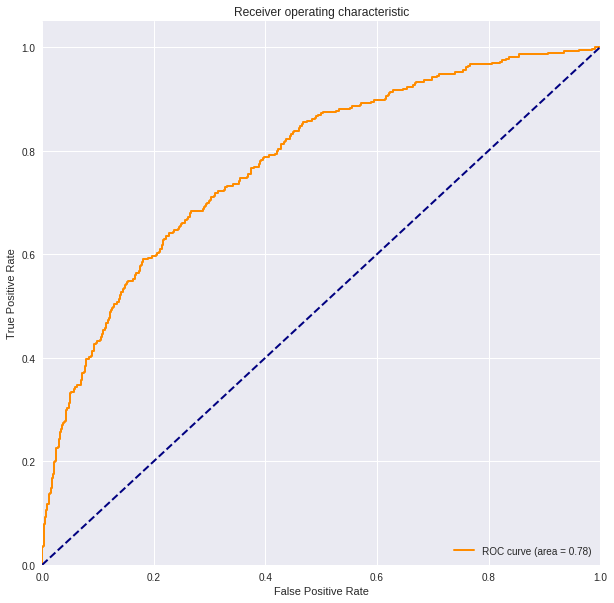

In [34]:
clf = GradientBoostingClassifier(n_estimators=100,
                                 random_state=2018)

clf.fit(over_samples_X, over_samples_y)

predict_Y = clf.predict(X_test)
predict_prob_y = clf.predict_proba(X_test)[:, 1]

acc = metrics.accuracy_score(Y_test,predict_Y)
auc = metrics.roc_auc_score(Y_test,predict_prob_y)
print(acc,auc)
print(metrics.classification_report(Y_test, predict_Y))

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(Y_test, predict_prob_y, pos_label=1)

lw = 2
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **建模: XGBoost**

0.7659425367904695 0.7532888902799078
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1068
           1       0.56      0.34      0.42       359

   micro avg       0.77      0.77      0.77      1427
   macro avg       0.68      0.63      0.64      1427
weighted avg       0.74      0.77      0.75      1427



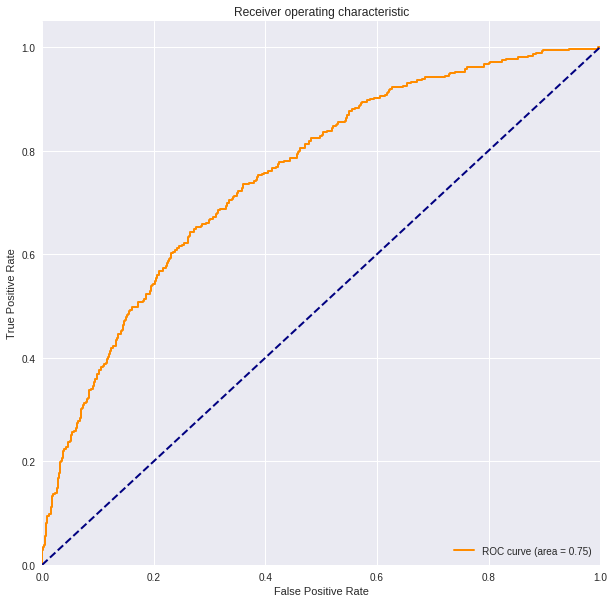

In [35]:
clf = xgb.XGBClassifier(silent=1, max_depth=10, n_estimators=1000, learning_rate=0.05)
clf.fit(X_train, Y_train)

predict_Y = clf.predict(X_test)
predict_prob_y = clf.predict_proba(X_test)[:, 1]

acc = metrics.accuracy_score(Y_test,predict_Y)
auc = metrics.roc_auc_score(Y_test,predict_prob_y)
print(acc,auc)
print(metrics.classification_report(Y_test, predict_Y))

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(Y_test, predict_prob_y, pos_label=1)

lw = 2
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **建模: LightGBM**

0.767344078486335 0.758515643746153
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1068
           1       0.55      0.40      0.46       359

   micro avg       0.77      0.77      0.77      1427
   macro avg       0.68      0.64      0.66      1427
weighted avg       0.75      0.77      0.75      1427



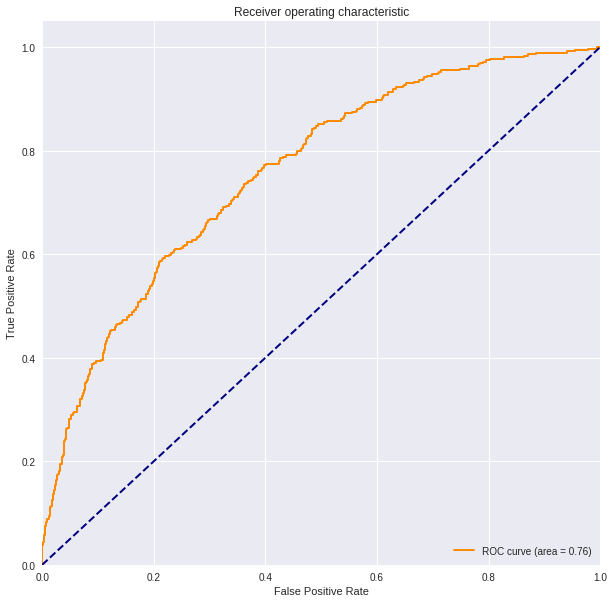

In [55]:
clf = LGBMClassifier()
clf.fit(over_samples_X, over_samples_y)

predict_Y = clf.predict(X_test)
predict_prob_y = clf.predict_proba(X_test)[:, 1]

acc = metrics.accuracy_score(Y_test,predict_Y)
auc = metrics.roc_auc_score(Y_test,predict_prob_y)
print(acc,auc)
print(metrics.classification_report(Y_test, predict_Y))

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(Y_test, predict_prob_y, pos_label=1)

lw = 2
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **总结及问题**

总结：
  
1. 004同学的将重复代码写成函数。直接一个函数调用。需要学习这种思路。怎样使得代码更加简洁精炼

2. SVM本身其实是不大受数据不平衡处理的，处理后的结果还是0.5，是否哪里存在问题？需要后续查看

3. LightBGM采用调参形式的输出，输出的是最佳AUC，不知道怎么根据最佳AUC去得到predict_Y, 然后画ROC。
